# Time series forecasting with DeepAR - Wikimedia pageview data

- This notebook we train a deepAR model using 2Years/ over all available of wiki-projects pageview data within requested time range, and test the model with both wiki and synthetic data.  
- Model pipeline: Request to Wiki REST api >> save_jason() to S3 bucket >> train model >> deploy trained model on Sagemaker, create endpoint >> request inference >> get prediction >> evaluation with test metric 

In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt
#from preprocessor import save_json

In [2]:
!conda install -y s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.6.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [3]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [4]:
bucket = 'sagemaker-deepar20190120'
prefix = 'sagemaker/wiki-test-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Predict setting

We predict the next 48 points of time series.
The time series that we use have hourly granularity.

In [6]:
freq = 'H'
prediction_length = 48

`context_length`: how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`.

In [7]:
context_length = 72

Useful functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3. (didn't call during this example)

In [8]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

### Get wikimedia pageview data from its REST API
We request the http requests sent by users to wiki projects. The output will be a json file with required format, each line contains hourly pageview numbers from `start` to `end`. Output files are saved in a S3 bucket.
- (A side note: wiki api allows 200 requests/s maximum, don't get blacklisted.)
- (Anote side note: the response will be json objects, each has a time stamp and corresponding time series values such as pageview, the maximum number of returned objects is 5000 that's why I use time delta = 200 days = 4800 objects for each request)

In [16]:
import datetime
import requests
import json
import time

all_data = []
project_list = []
delta = datetime.timedelta(days=199)
hour = datetime.timedelta(hours=1)
zero = datetime.timedelta(hours=0)


def save_json(start, end, out_path, input_path):
    s3filesystem = s3fs.S3FileSystem()
    start_date = datetime.datetime.strptime(start, '%Y%m%d')
    end_date = datetime.datetime.strptime(end, '%Y%m%d')
    if (end_date - start_date).days < 0:
        raise Exception('start date should NOT after end date')

    expected_size = ((end_date - start_date).days + 1) * 24

    # provide wiki-project list here!
    with open(input_path) as f:
        projects = f.read().splitlines()

    for item in projects:
        data = get_single_views(item, start_date, end_date)
        if len(data['target']) == expected_size:
            all_data.append(data)
            project_list.append(item)

    # convert all items to JSON and write to a file
    print('saving data')
    print(project_list)
    with open(input_path[:-4] + '-' + str(start) + '-' + str(end) + '-get.txt', 'w') as f:
        for item in project_list:
            f.write("%s\n" % item)
    with s3filesystem.open(out_path, 'w') as outfile:
        outfile.write('\n'.join(json.dumps(i) for i in all_data) + '\n')
    all_data.clear()
    project_list.clear()


def get_single_views(item, start_date, end_date):
    base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/' \
               + item \
               + '/all-access/user/hourly/'
    # dict is used to save JSON of each domain
    data = dict()
    data['start'] = start_date.strftime('%Y-%m-%d') + ' 00:00:00'
    data['target'] = []

    while start_date <= end_date:
        if start_date + delta <= end_date:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + (start_date + delta).strftime('%Y%m%d') + '23'
            end_check = start_date + delta + 23 * hour
        else:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + end_date.strftime('%Y%m%d') + '23'
            end_check = end_date + 23 * hour
        # make a API request here!!!
        response = requests.get(final_url)
        time.sleep(0.05)
        try:
            response.raise_for_status()
        except requests.exceptions.HTTPError as e:
            print("<-----Error---->: " + final_url + str(e))
            break
        print('<-----OK----->' + final_url)  # debug
        output = response.json()
        print('processed data points: ' + str(len(output['items'])))  # debug
        temp = start_date - hour
        for i in output['items']:
            curr = datetime.datetime.strptime(i['timestamp'], '%Y%m%d%H')
            while curr - temp > hour:
                data['target'].append(None)
                temp += hour
            data['target'].append(i['views'])
            temp = curr

        while (end_check - temp) > zero:
            data['target'].append(None)
            temp += hour

        start_date += datetime.timedelta(days=200)

    return data

In [ ]:
train_start = '20160101'
train_end = '20171231'
save_json(train_start,train_end,s3_data_path + "/train_0toNaN/train.json", 'wp_full.txt')
test_start = '20180101'
test_end = '20181231'
save_json(test_start,test_end,s3_data_path + "/test_0toNaN/test.json", 'wp_full.txt')

### Train a model

In [10]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

In [11]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [12]:
estimator.set_hyperparameters(**hyperparameters)

In [14]:
data_channels = {
    "train": "s3://{}/train_0toNaN_1/".format(s3_data_path),
    "test": "s3://{}/test_0toNaN/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2019-01-30-15-48-24-121


2019-01-30 15:48:24 Starting - Starting the training job...
2019-01-30 15:48:25 Starting - Launching requested ML instances......
2019-01-30 15:49:25 Starting - Preparing the instances for training......
2019-01-30 15:50:45 Downloading - Downloading input data..
Arguments: train
[01/30/2019 15:51:03 INFO 139681102190400] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[01/30/2019 15:51:03 INFO 139681102190400] Reading provided configuration from /opt/ml/input/

[01/30/2019 15:51:30 INFO 139681102190400] Epoch[2] Batch[10] avg_epoch_loss=6.869562
[01/30/2019 15:51:30 INFO 139681102190400] Epoch[2] Batch [10]#011Speed: 91.42 samples/sec#011loss=6.988784
[01/30/2019 15:51:31 INFO 139681102190400] Epoch[2] Batch[15] avg_epoch_loss=6.734302
[01/30/2019 15:51:31 INFO 139681102190400] Epoch[2] Batch [15]#011Speed: 175.70 samples/sec#011loss=6.436729
[01/30/2019 15:51:32 INFO 139681102190400] Epoch[2] Batch[20] avg_epoch_loss=7.287291
[01/30/2019 15:51:32 INFO 139681102190400] Epoch[2] Batch [20]#011Speed: 104.87 samples/sec#011loss=9.056856
[01/30/2019 15:51:33 INFO 139681102190400] processed a total of 790 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6999.147176742554, "sum": 6999.147176742554, "min": 6999.147176742554}}, "EndTime": 1548863493.593503, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548863486.594042}

[01/30/2019 15:51:33 INFO 139681102190400] #throughput_metri

[01/30/2019 15:52:01 INFO 139681102190400] Epoch[6] Batch[20] avg_epoch_loss=6.751801
[01/30/2019 15:52:01 INFO 139681102190400] Epoch[6] Batch [20]#011Speed: 112.14 samples/sec#011loss=6.367268
[01/30/2019 15:52:02 INFO 139681102190400] Epoch[6] Batch[25] avg_epoch_loss=6.752682
[01/30/2019 15:52:02 INFO 139681102190400] Epoch[6] Batch [25]#011Speed: 164.96 samples/sec#011loss=6.756380
[01/30/2019 15:52:02 INFO 139681102190400] processed a total of 830 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 7256.867170333862, "sum": 7256.867170333862, "min": 7256.867170333862}}, "EndTime": 1548863522.404893, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548863515.147616}

[01/30/2019 15:52:02 INFO 139681102190400] #throughput_metric: host=algo-1, train throughput=114.371842166 records/second
[01/30/2019 15:52:02 INFO 139681102190400] #progress_metric: host=algo-1, completed 35 % of epochs
[01/30/2019 15:52:02 INFO 1396811

[01/30/2019 15:52:32 INFO 139681102190400] Epoch[11] Batch[5] avg_epoch_loss=6.677786
[01/30/2019 15:52:32 INFO 139681102190400] Epoch[11] Batch [5]#011Speed: 172.87 samples/sec#011loss=6.677786
[01/30/2019 15:52:34 INFO 139681102190400] Epoch[11] Batch[10] avg_epoch_loss=6.908955
[01/30/2019 15:52:34 INFO 139681102190400] Epoch[11] Batch [10]#011Speed: 87.50 samples/sec#011loss=7.186358
[01/30/2019 15:52:35 INFO 139681102190400] Epoch[11] Batch[15] avg_epoch_loss=6.741089
[01/30/2019 15:52:35 INFO 139681102190400] Epoch[11] Batch [15]#011Speed: 162.00 samples/sec#011loss=6.371785
[01/30/2019 15:52:37 INFO 139681102190400] Epoch[11] Batch[20] avg_epoch_loss=6.709077
[01/30/2019 15:52:37 INFO 139681102190400] Epoch[11] Batch [20]#011Speed: 107.12 samples/sec#011loss=6.606635
[01/30/2019 15:52:38 INFO 139681102190400] Epoch[11] Batch[25] avg_epoch_loss=6.640569
[01/30/2019 15:52:38 INFO 139681102190400] Epoch[11] Batch [25]#011Speed: 165.19 samples/sec#011loss=6.352838
[01/30/2019 15:52:

[01/30/2019 15:53:13 INFO 139681102190400] Epoch[16] Batch[20] avg_epoch_loss=6.252089
[01/30/2019 15:53:13 INFO 139681102190400] Epoch[16] Batch [20]#011Speed: 105.84 samples/sec#011loss=6.094511
[01/30/2019 15:53:14 INFO 139681102190400] Epoch[16] Batch[25] avg_epoch_loss=6.211836
[01/30/2019 15:53:14 INFO 139681102190400] Epoch[16] Batch [25]#011Speed: 166.73 samples/sec#011loss=6.042772
[01/30/2019 15:53:14 INFO 139681102190400] processed a total of 825 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 7306.412935256958, "sum": 7306.412935256958, "min": 7306.412935256958}}, "EndTime": 1548863594.619681, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548863587.313204}

[01/30/2019 15:53:14 INFO 139681102190400] #throughput_metric: host=algo-1, train throughput=112.912559598 records/second
[01/30/2019 15:53:14 INFO 139681102190400] #progress_metric: host=algo-1, completed 85 % of epochs
[01/30/2019 15:53:14 INFO 139

[01/30/2019 15:54:04 INFO 139681102190400] Number of test batches scored: 10
[01/30/2019 15:54:27 INFO 139681102190400] Number of test batches scored: 20
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 59567.40403175354, "sum": 59567.40403175354, "min": 59567.40403175354}}, "EndTime": 1548863680.840132, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548863621.27284}

[01/30/2019 15:54:40 INFO 139681102190400] #test_score (algo-1, RMSE): 80115.6923455
[01/30/2019 15:54:40 INFO 139681102190400] #test_score (algo-1, mean_wQuantileLoss): 0.34046
[01/30/2019 15:54:40 INFO 139681102190400] #test_score (algo-1, wQuantileLoss[0.1]): 0.297429
[01/30/2019 15:54:40 INFO 139681102190400] #test_score (algo-1, wQuantileLoss[0.2]): 0.397199
[01/30/2019 15:54:40 INFO 139681102190400] #test_score (algo-1, wQuantileLoss[0.3]): 0.380276
[01/30/2019 15:54:40 INFO 139681102190400] #test_score (algo-1, wQuantileLoss[0.4]): 0.311666
[01/30/20

### Create endpoint and predictor

In [15]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-01-30-15-48-24-121
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-01-30-15-48-24-121
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-01-30-15-48-24-121


-------------------------------------------------------------------------!

In [17]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [18]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make predictions, plot and evaluate the results

### Make prediction for `wiki` data

In [19]:
data_location = "s3://{}/test/test.json".format(s3_data_path)
df_ts = pd.read_json(data_location, lines = True)
df_ts.head()

,start,target
0,2018-01-01 00:00:00,"[93, 6, 12, 17, 113, 17, 70, 5, 100, 92, 51, 1..."
1,2018-01-01 00:00:00,"[0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 1, 1, 0, 2, 1, ..."
2,2018-01-01 00:00:00,"[0, 1, 1, 1, 1, 2, 1, 7, 3, 0, 7, 5, 1, 0, 3, ..."
3,2018-01-01 00:00:00,"[69, 74, 102, 102, 104, 65, 65, 79, 55, 108, 2..."
4,2018-01-01 00:00:00,"[0, 0, 2, 1, 0, 2, 1, 1, 0, 0, 7, 4, 2, 0, 1, ..."


In [20]:
num_pt = len(df_ts.iloc[1,1])
num_ts = len(df_ts)

time_series_wiki = [] 
for k in range(num_ts-1):
    t0 = df_ts.iloc[k,0]
    data = df_ts.iloc[k,1]
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
    time_series_wiki.append(pd.Series(data=data, index=index))

In [21]:
time_series_wiki_predict = []
for ts in time_series_wiki:
    time_series_wiki_predict.append(ts[:-prediction_length])

In [22]:
# result of prediction will be stored in list_of_wiki_pred
list_of_wiki_pred = []
for i in range(0,len(time_series_wiki_predict)):
    list_of_wiki_pred.append(predictor.predict(time_series_wiki_predict[i:i+1]))
    # The following line is added to avoid time out error.
    time.sleep(0.05) 

### A quick overview of the prediction

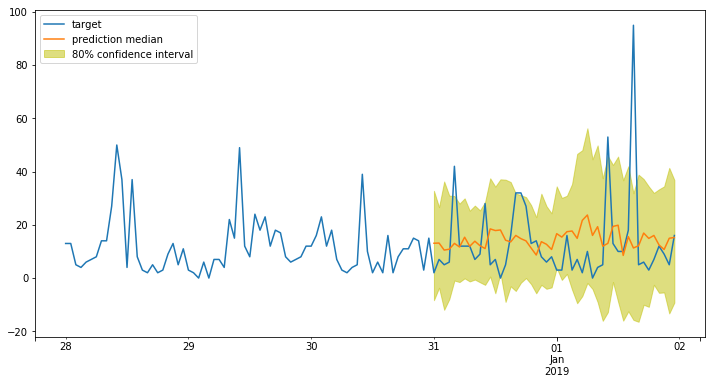

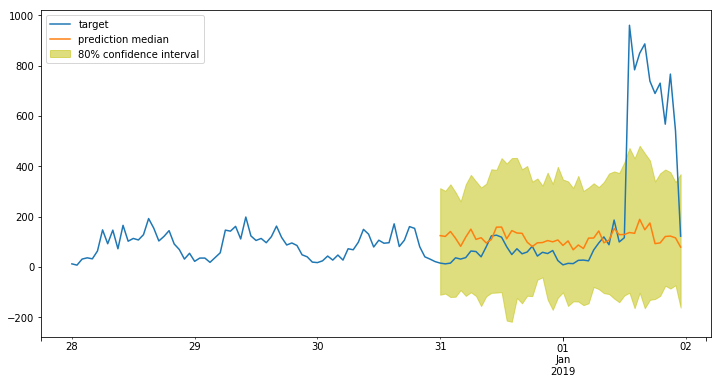

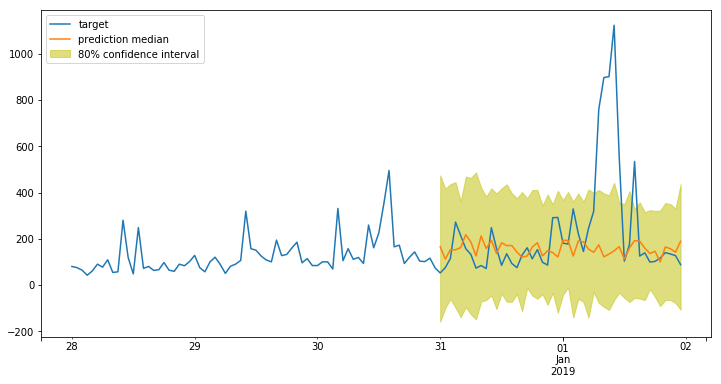

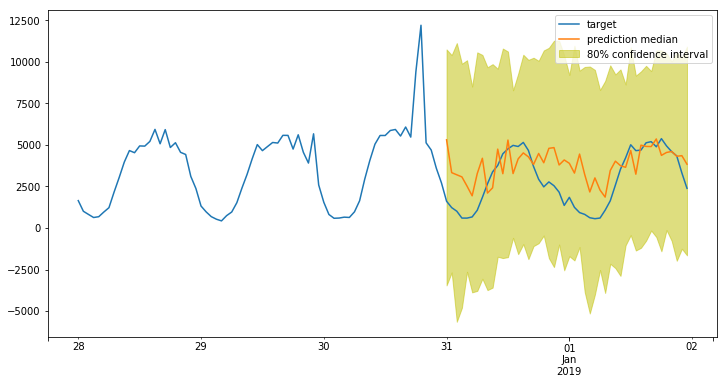

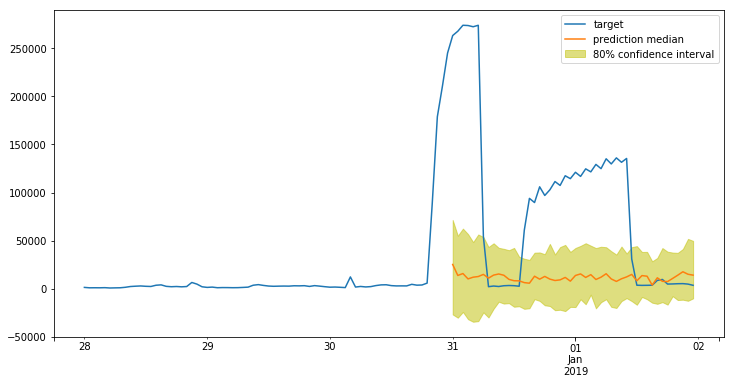

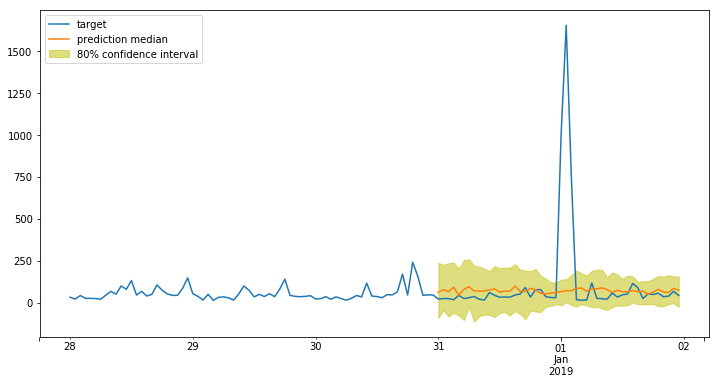

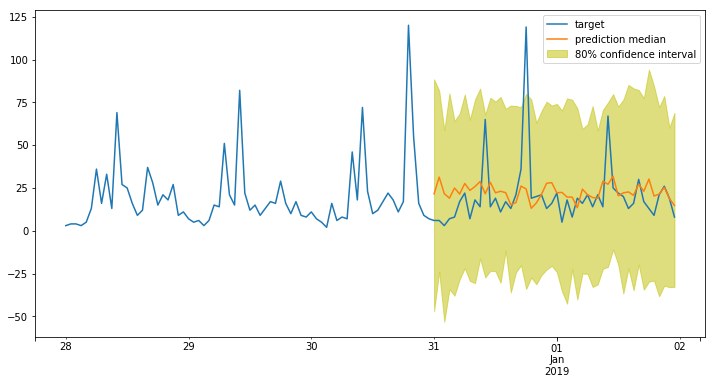

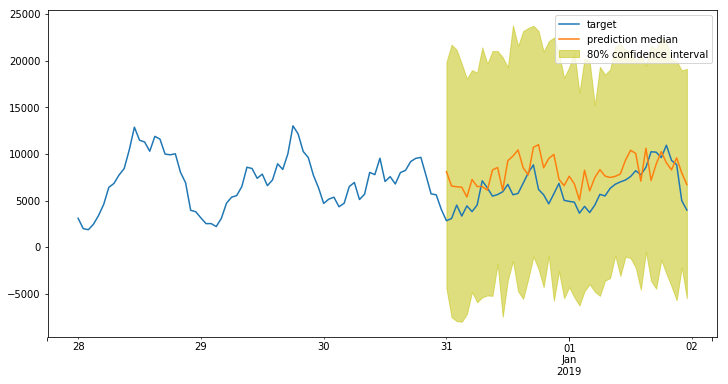

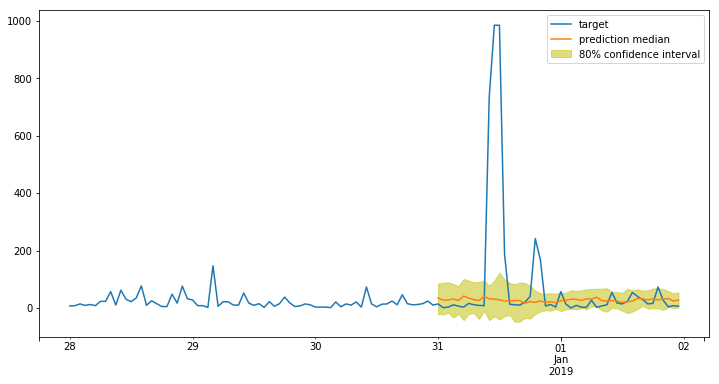

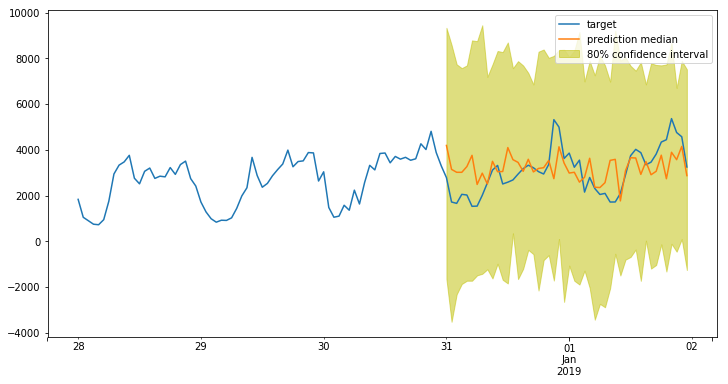

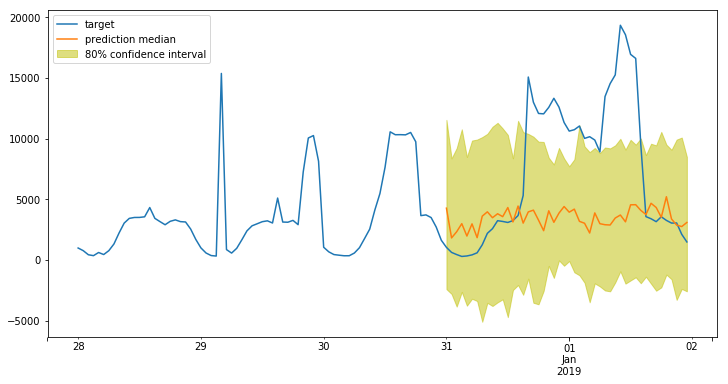

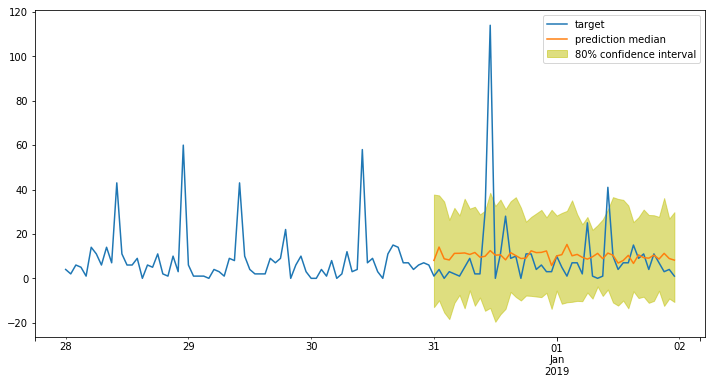

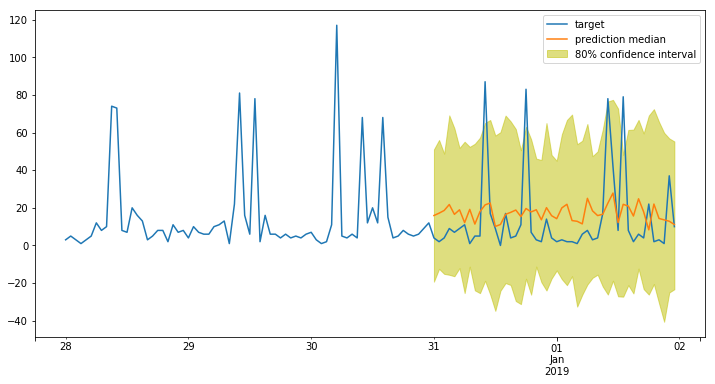

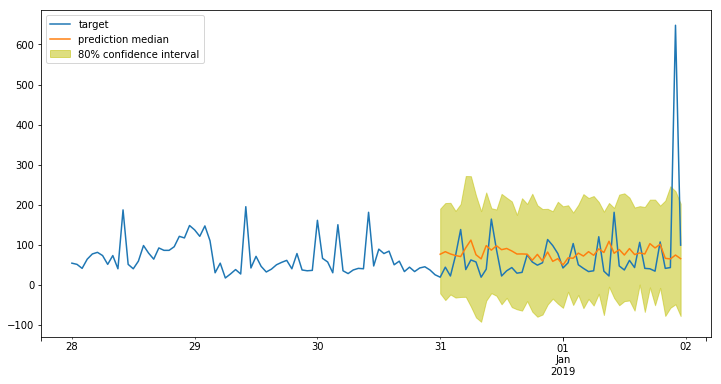

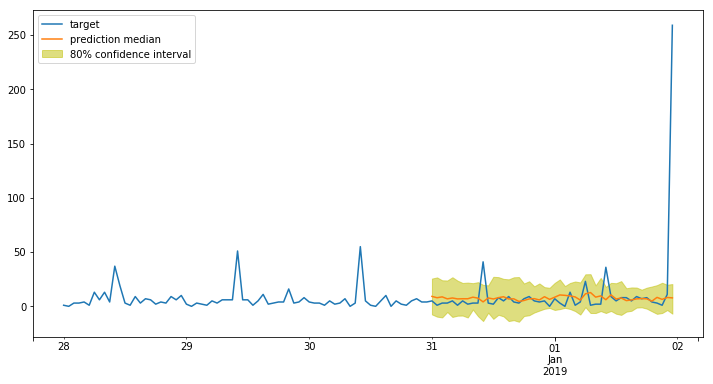

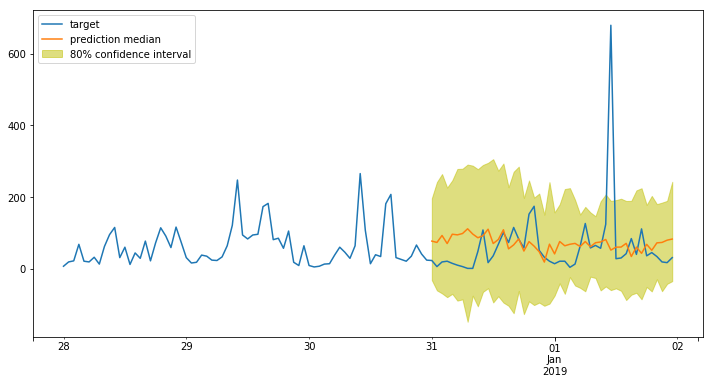

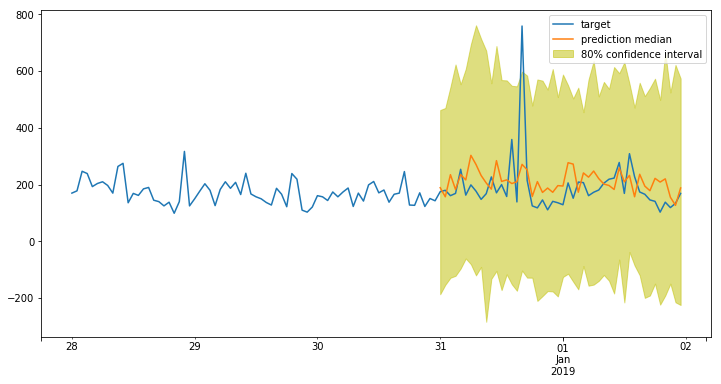

In [23]:
# sample several predicted time series use range(0, len(list_of_wiki_pred), 50)
for k in range(0, len(list_of_wiki_pred), 50):
    plt.figure(figsize=(12,6))
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.legend(loc = 'best')
    plt.show()

### Metrics to evaluate the prediction
- Mean absolute percentage error
- Mean absolute error with log1p
- Symmetric mean absolute percentage error
- Symmetric mean absolute percentage error differentiable
- others?

In [24]:
# Approximated differentiable SMAPE
def differentiable_smape(true, predicted):
    epsilon = 0.1
    true_o = true
    pred_o = predicted
    summ = np.maximum(np.abs(true_o) + np.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = np.abs(pred_o - true_o) / summ
    return smape

# SMAPE, rounded up to the closest integer
def rounded_smape(true, predicted):
    true_o = np.int(np.round(true))
    pred_o = np.round(predicted).astype(np.int32)
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# SMAPE stardard definition
def smape(true, predicted):
    true_o = true
    pred_o = predicted
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# MAE standard definition
def mape(true, predicted):
    true_o = true
    pred_o = predicted
    denom = np.abs(true_o)
    mape = np.where(denom==0, 0, np.abs(pred_o - true_o) / denom)
    return mape


# MAE on log1p
def mape1p(true, predicted):
    epsilon = 0.1
    true_o = np.log1p(true + epsilon)
    pred_o = np.log1p(predicted + epsilon)
    error = np.where(np.abs(true_o)==0, 0, np.abs(pred_o - true_o) / np.abs(true_o))
#     error = np.abs(true_o - pred_o)/np.abs(true_o)
    return error

In [25]:
# input pd.series in which index = time stamps, value = time series values
# actual_series and pred_series should have exactly matched timestamps

def plot_metrics(actual_series, pred_series):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    metric_smape = differentiable_smape(actual_series.values, pred_series.values)
    metric_mape = mape(actual_series.values, pred_series.values)
    metric_maelog1p = mape1p(actual_series.values, pred_series.values)
    metric_smape_orig = smape(actual_series.values, pred_series.values)
    plt.figure(figsize=(12,6))
    plt.plot(pred_series.index, metric_smape_orig, label = 'smape standard = {}'.format(metric_smape_orig.mean()))  
    plt.plot(pred_series.index, metric_smape, label = 'smape differentialble = {}'.format(metric_smape.mean()))
    plt.plot(pred_series.index, metric_mape, label = 'mape standard = {}'.format(metric_mape.mean()))
    plt.plot(pred_series.index, metric_maelog1p, label = 'mape with log(1 + epsilon +val) = {}'.format(metric_maelog1p.mean()))
    plt.xlabel('Time stamp of prediction')
    plt.ylabel('Prediction metric')
    plt.legend(loc = 'best')
    plt.show()

### Plot the metrics for wiki data prediction

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide


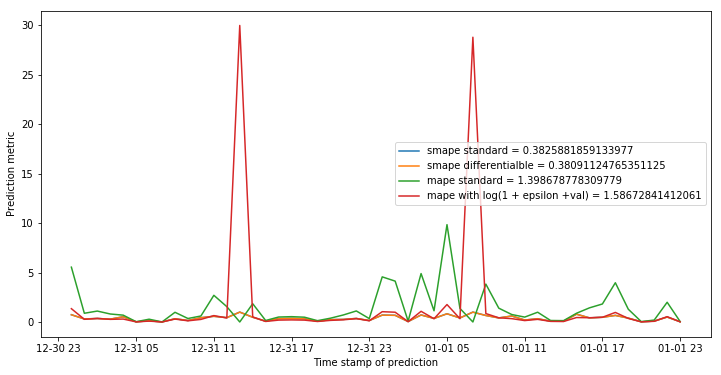

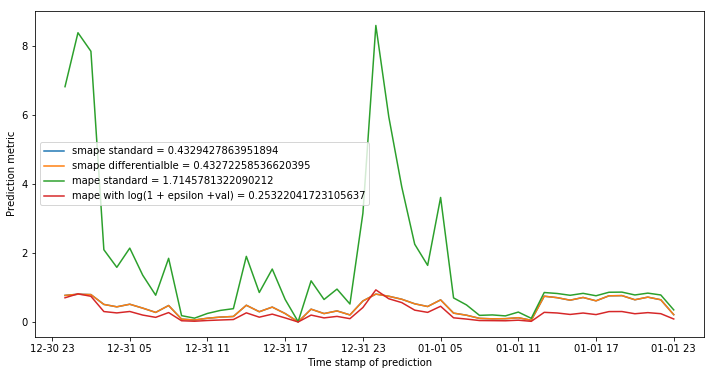

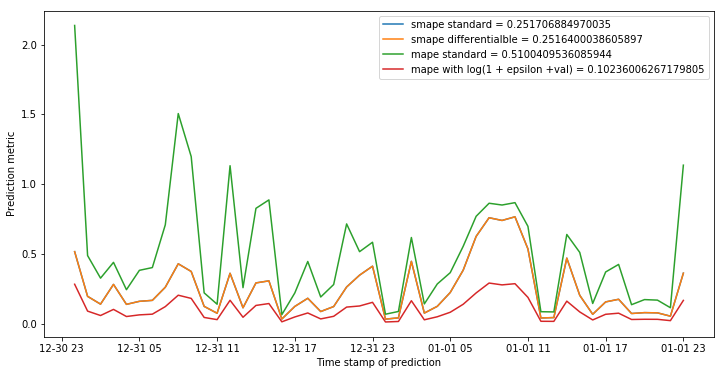

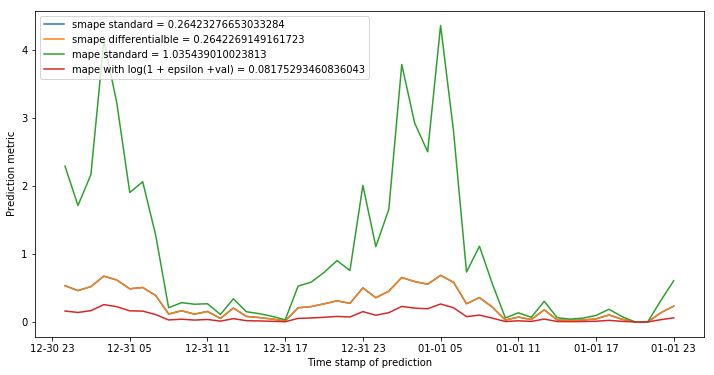

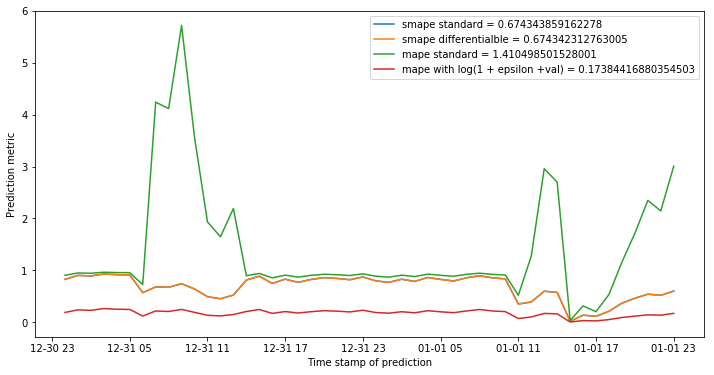

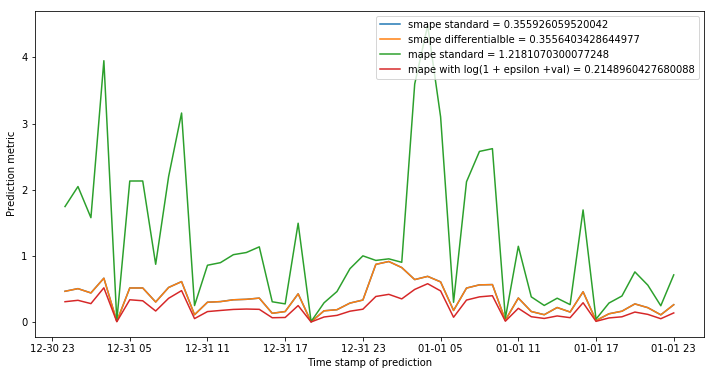

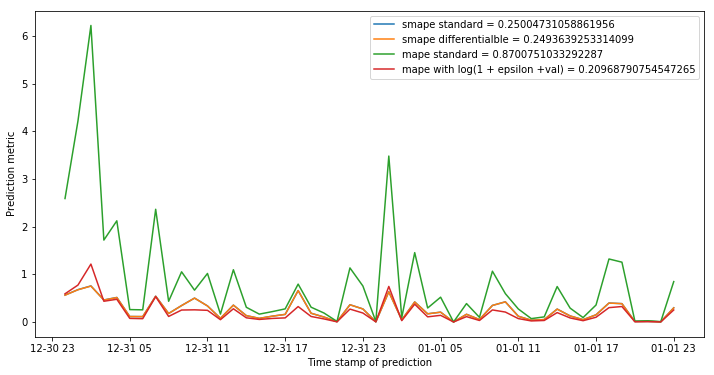

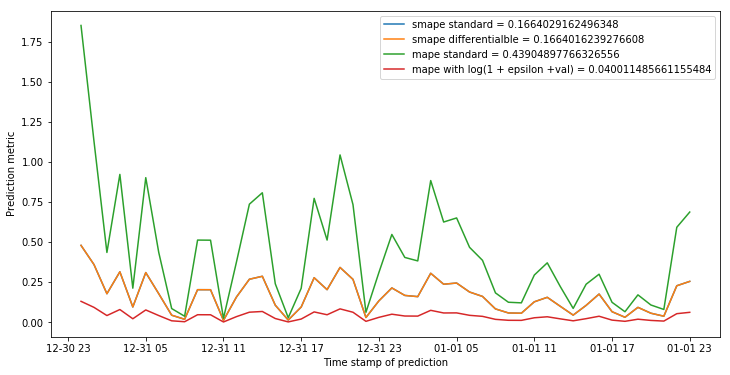

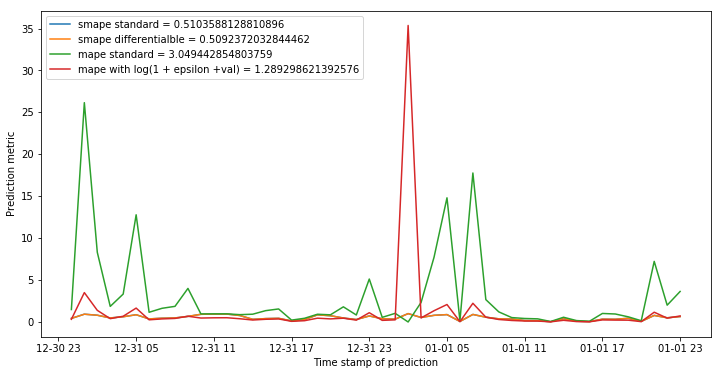

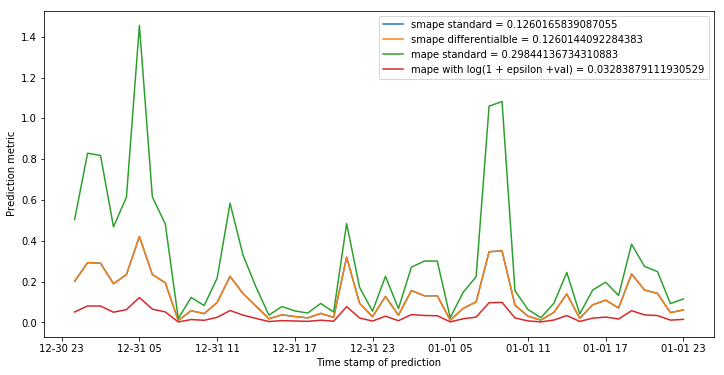

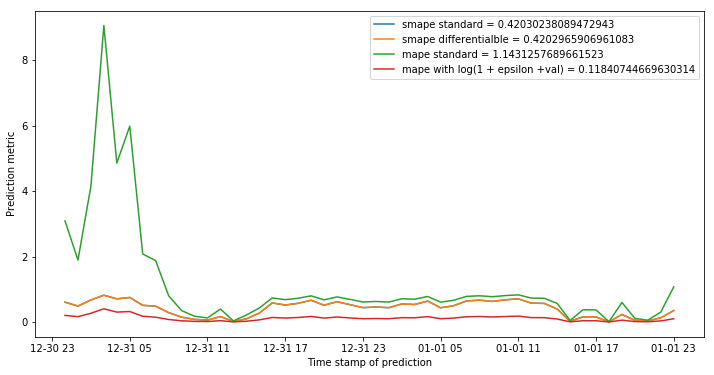

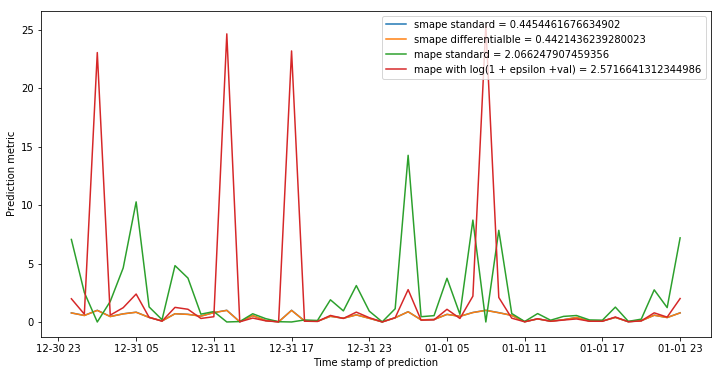

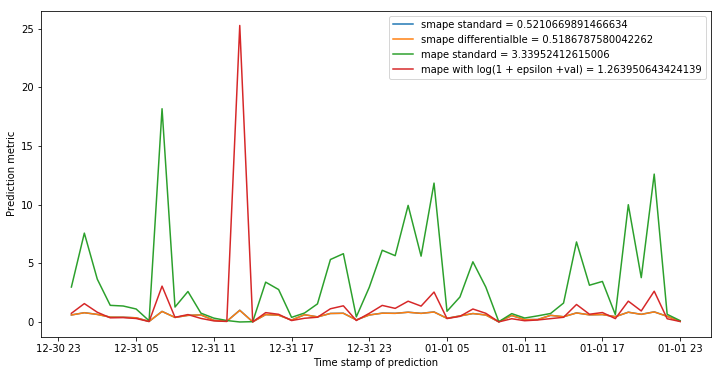

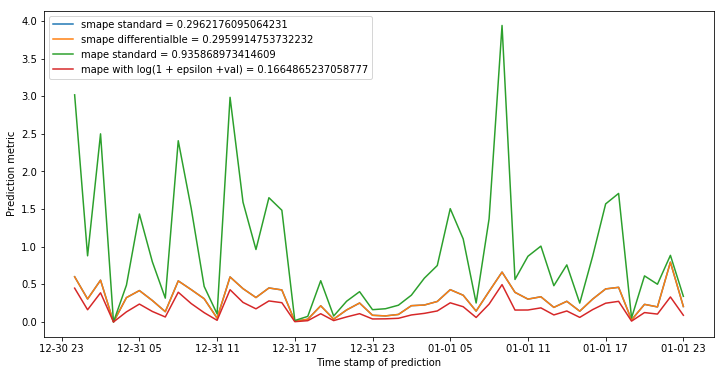

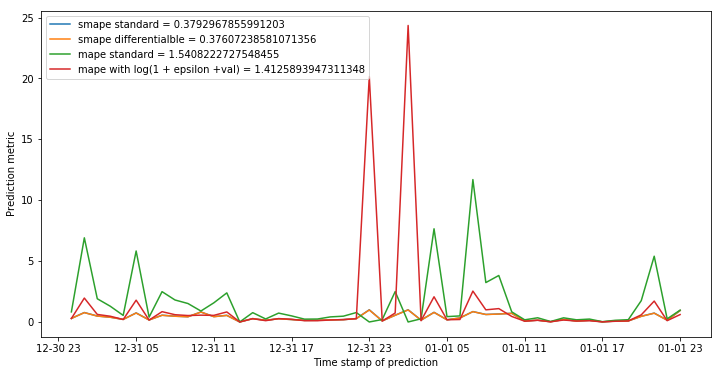

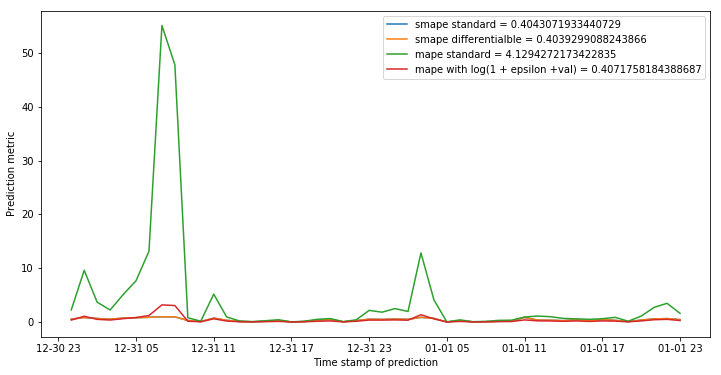

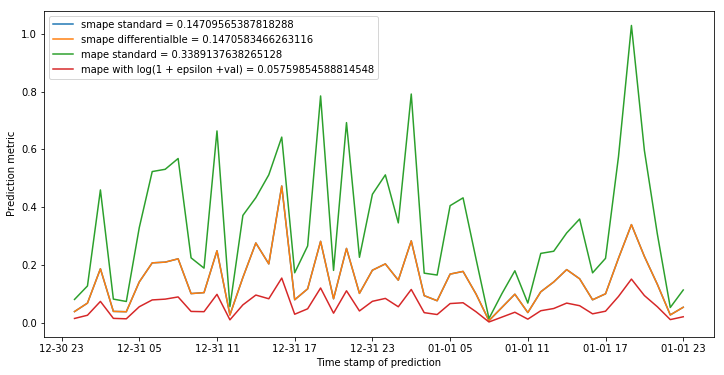

In [26]:
for k in range(0, len(list_of_wiki_pred), 50):
    plot_metrics(time_series_wiki[k][-prediction_length:], list_of_wiki_pred[k][0]['0.5'])


In [27]:
import heapq
# This function characterize time series with FFT.
def characterize_ts(ts,window):
    y = ts.values # signal
    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    # We only keep the positive frequency up to the Nyquist = 1/(2*dT), dT = sampling interval.
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half
    yabs = np.abs(Y)
    
    # Locate the largest 15 peaks, use them to characterise the time series.
    indx = heapq.nlargest(15, range(len(yabs)), yabs.__getitem__)
    amp = heapq.nlargest(15,yabs)

    mean = yabs.mean()
    std = yabs.std()
    cyc_hday = 2.0
    cyc_day = cyc_hday / 2.0
    cyc_week = cyc_day / 7.0
    cyc_month = cyc_day / 30.0

    comp = lambda a,b : np.abs(a/b - 1) < 0.05
    ts_type = ['trend', 'hDay', 'Day', 'Week', 'Month', 'DayImpulse', 'spike']
    report_list = [0] * 8
    for counter, value in enumerate(indx):
        # Here we define a peak in frequency domain.
        if amp[counter] > (mean + 3*std):
            amp_norm = (amp[counter] - mean)/std
            if cycle[value] < 0.01:
                # trend (increasing, decreasing, gaussian pulse)
                report_list[0] = max(amp_norm,report_list[0])
            elif comp(cycle[value], cyc_hday):
                report_list[1] = max(amp_norm,report_list[1])
            elif comp(cycle[value], cyc_day):
                report_list[2] = max(amp_norm,report_list[2])
            elif comp(cycle[value], cyc_week):
                report_list[3] = max(amp_norm,report_list[3])
            elif comp(cycle[value], cyc_month):
                report_list[4] = max(amp_norm,report_list[4])

    if sum(report_list[:4]) > 0:
        index = report_list[:4].index(max(report_list[:4])) 
        report_list[5] = ts_type[index]
    else: 
        report_list[5] = ts_type[-1]
        
    # Add a subcategory: a special day seasonality that has a periodic impulse shape.    
    if (report_list[5] == 'hDay' or report_list[5] == 'Day'):
        harmonic = set(range(12))
        all_peak = set()
        for counter, value in enumerate(indx):
            if amp[counter] > (mean + 3*std):
                all_peak.add(int(round(cycle[value])))
        if len(harmonic.intersection(all_peak)) > 10 :
            report_list[5] = ts_type[-2]

    report_list[-2] = y.mean()
    report_list[-1] = y.std()
    return report_list

In [28]:
character_list = []
day = 24
for item in time_series_wiki:
    character_list.append(characterize_ts(item,day))

In [29]:
error_list = []
for i in range(len(list_of_wiki_pred)):
    metric_smape = differentiable_smape(time_series_wiki[i][-prediction_length:].values, 
                                        list_of_wiki_pred[i][0]['0.5'].values)
    error_list.append(metric_smape.mean())

### By classifying the time series into different buckets, we can see how the model performs on different types of time series.

- The major types of time series in the wiki dataset are: Day seasonality, Trend seasonality. We also observe a small population of HalfDay seasonality time series as well.

- The SMAPE score for the two major types Day seasonality = 25.0985% and Trend = 34.8699% is still decent (in comparison with the Kaggle competition for wiki day page view best SMAPE = 35.48065%).

- But we see the model performance varies to some extent according to the scale or type.

trend  smape  0.3486985796984094  number of series  305
hDay  smape  0.33064986281818964  number of series  5
Day  smape  0.25098420903382973  number of series  352
spike  smape  0.3212437400567001  number of series  3
DayImpulse  smape  0.47019407413758146  number of series  141


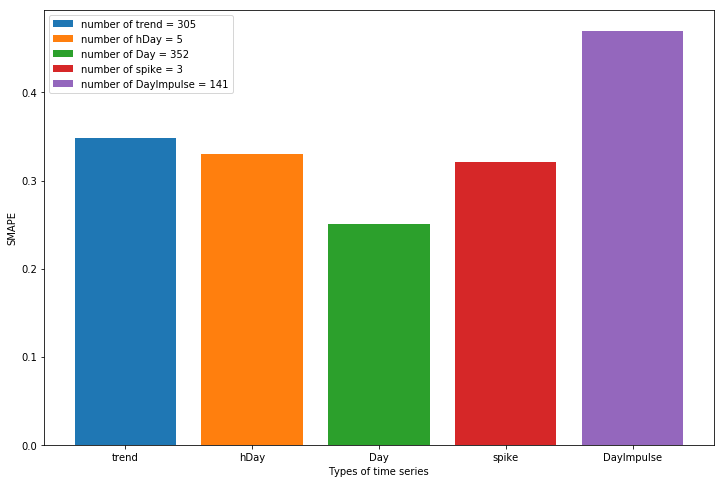

In [30]:
ans = {}
# we have ['trend', 'halfDay', 'Day', 'Week', 'Month', 'spike']
ans['trend'] = []
ans['hDay'] = []
ans['Day'] = []
ans['Week'] = []
ans['Month'] = []
ans['spike'] = []
ans['DayImpulse'] = []

for i in range(len(error_list)):
    ans[character_list[i][5]].append(error_list[i])

plt.figure(figsize=(12,8))  
for key, value in ans.items():
    if value:
        print(key, ' smape ', np.mean(value), ' number of series ', len(value))
        plt.bar(key, np.mean(value), label = 'number of {} = {}'.format(key, len(value)))
plt.xlabel('Types of time series')
plt.ylabel('SMAPE')
plt.legend()
plt.show()

### Examine Trend type time series, the error distribution, and will the scale affect the error?

- By plotting the scale (mean amplitude, consistent with the deepAR paper) vs the corresponding SMAPE, we see a correlation here.

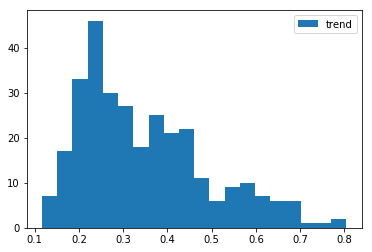

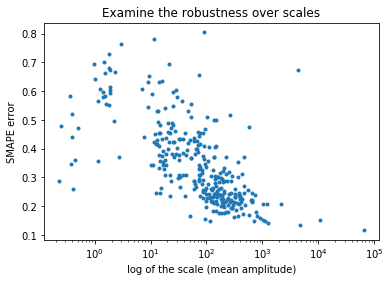

In [64]:
plt.figure()
plt.hist(ans['trend'], bins = 20, label = 'trend')
# plt.plot(ans['Day'], label = 'day')
plt.legend()
plt.show()

trend_mean = []
trend_error = []
bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'trend'):
        trend_mean.append(character_list[index][6])
        trend_error.append(error_list[index])
        if (error < 0.15 and character_list[index][6] > 1000):
            good_index.append(index)
        elif (error > 0.5 and character_list[index][6] > 1000):
            bad_index.append(index) 

plt.figure()
plt.plot((trend_mean), trend_error, '.')
plt.xscale('log')
plt.xlabel('log of the scale (mean amplitude)')
plt.ylabel('SMAPE error')
plt.title('Examine the robustness over scales')
plt.show()

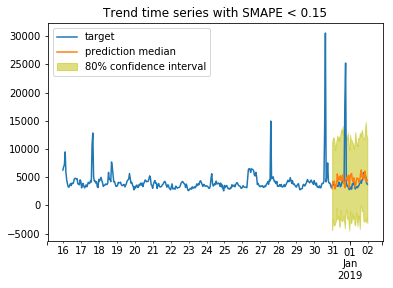

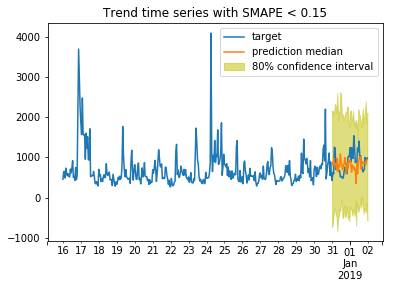

In [65]:
for k in good_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*5:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Trend time series with SMAPE < 0.15')
    plt.legend(loc = 'best')
    plt.show() 

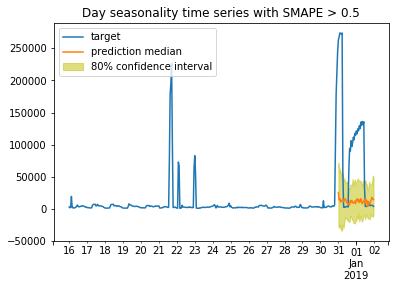

In [67]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*5:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE > 0.5')
    plt.legend(loc = 'best')
    plt.show()   

### Examine the Day seasonality type time series, the error distribution, and will the scale affect the error?

- Similar to the trend type, we see a correlation between the scale and the SMAPE. The model performs better for larger scales (i.e. time series for popular wiki projects).

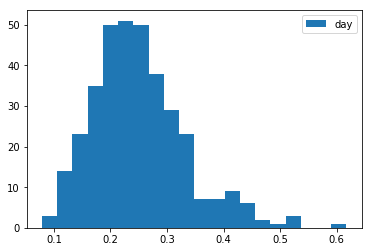

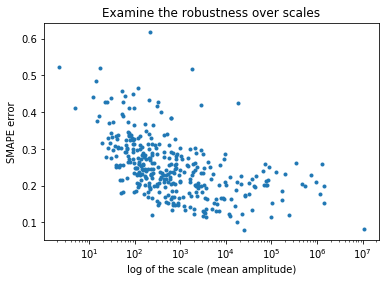

In [68]:
plt.figure()
plt.hist(ans['Day'], bins = 20, label = 'day')
plt.legend()
plt.show()

day_mean = []
day_error = []
bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'Day'):
        day_mean.append(character_list[index][6])
        day_error.append(error_list[index])
        if error < 0.15:
            good_index.append(index)
        elif error > 0.5:
            bad_index.append(index)    

plt.figure()
plt.plot((day_mean), day_error, '.')
plt.xscale('log')
plt.xlabel('log of the scale (mean amplitude)')
plt.ylabel('SMAPE error')
plt.title('Examine the robustness over scales')
plt.show()

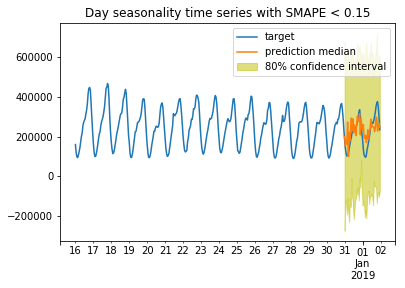

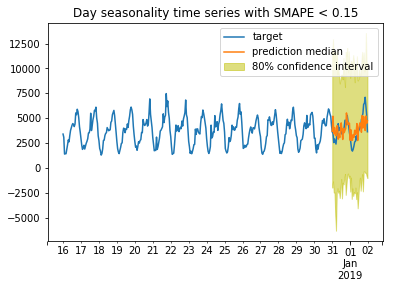

In [69]:
for k in good_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*5:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE < 0.15')
    plt.legend(loc = 'best')
    plt.show()    

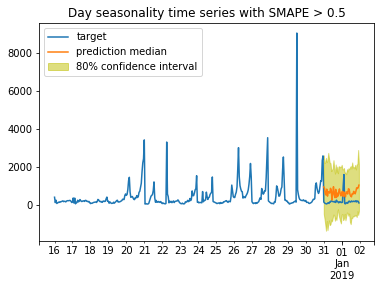

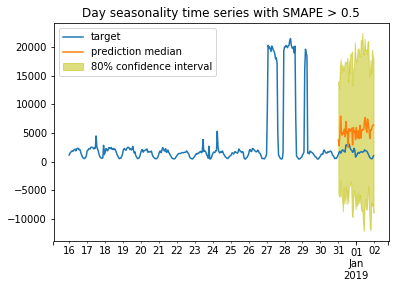

In [70]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*5:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE > 0.5')
    plt.legend(loc = 'best')
    plt.show()    

### Examine DayImpulse type time series, why it has such high error?

Find the ones with high SMAPE (> 0.7), and see how the actual and prediction compare to each other.

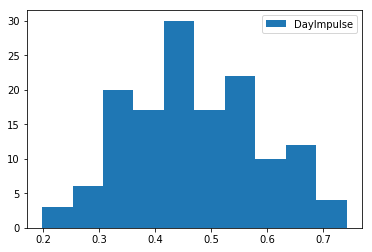

In [71]:
plt.figure()
plt.hist(ans['DayImpulse'], label = 'DayImpulse')
plt.legend()
plt.show()

bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'DayImpulse' and error > 0.7):
        bad_index.append(index)
    elif (character_list[index][5] == 'DayImpulse' and error < 0.3):
        good_index.append(index)

#### Now we take a look at the good and bad examples: we plot shorter length (only keep the context + prediction) to better zoom in.

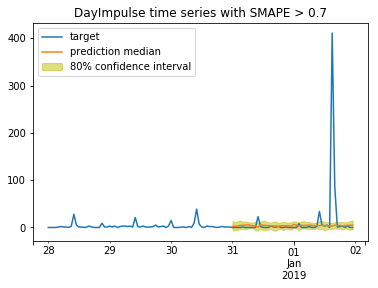

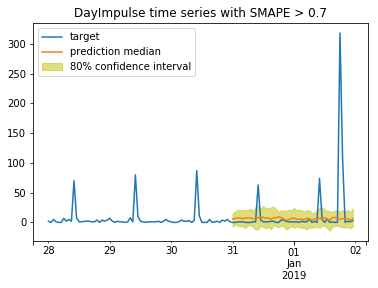

In [57]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('DayImpulse time series with SMAPE > 0.7')
    plt.legend(loc = 'best')
    plt.show()    

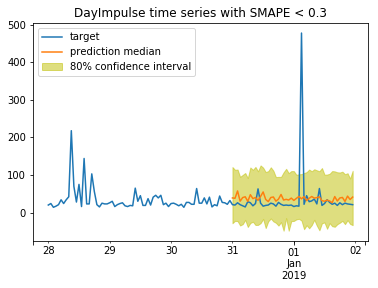

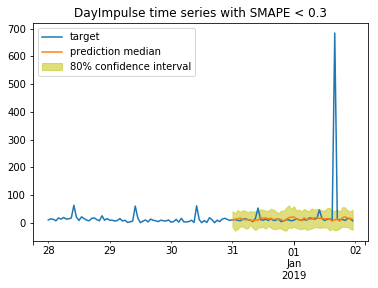

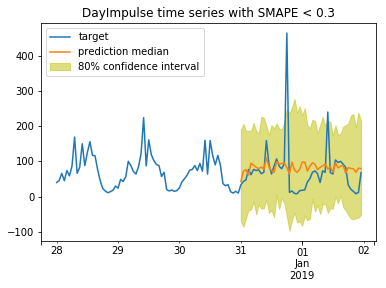

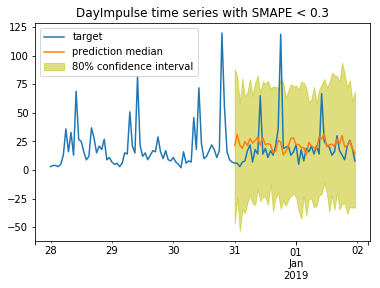

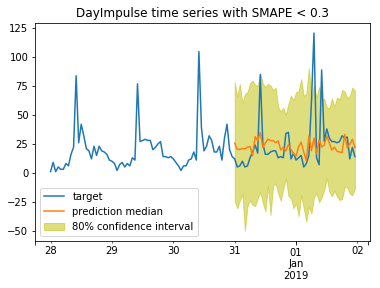

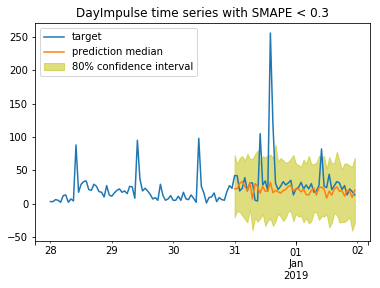

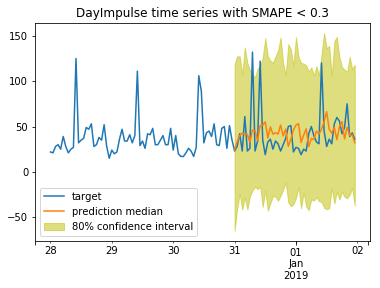

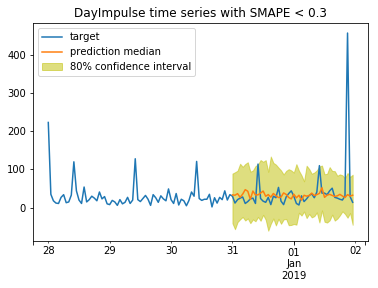

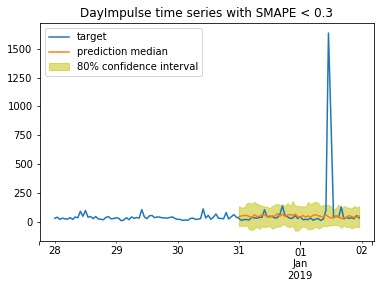

In [58]:
for k in good_index:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('DayImpulse time series with SMAPE < 0.3')
    plt.legend(loc = 'best')
    plt.show()   

### Delete endpoint

In [52]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DEMO-deepar-2019-01-30-15-48-24-121
